In [799]:
import pandas as pd
import seaborn as sns
import numpy as np
import matplotlib.pyplot as plt
from sklearn import preprocessing
from sklearn.preprocessing import StandardScaler
from sklearn.linear_model import LinearRegression, Lasso
import xgboost as xgb

In [800]:
train = pd.read_csv('data/train.csv')
test = pd.read_csv('data/test.csv')

In [801]:
print(str(train.shape)+", "+str(test.shape))

(1460, 81), (1459, 80)


(array([148., 723., 373., 135.,  51.,  19.,   4.,   3.,   2.,   2.]),
 array([ 34900., 106910., 178920., 250930., 322940., 394950., 466960.,
        538970., 610980., 682990., 755000.]),
 <BarContainer object of 10 artists>)

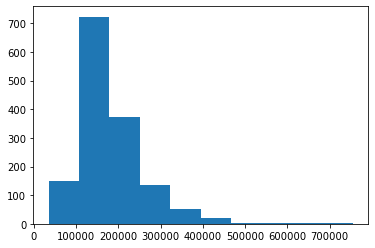

In [802]:
# Plotting histogram for sale price of homes in the training set
plt.hist(train["SalePrice"])

(array([  5.,  12.,  54., 184., 470., 400., 220.,  90.,  19.,   6.]),
 array([10.46024211, 10.7676652 , 11.07508829, 11.38251138, 11.68993448,
        11.99735757, 12.30478066, 12.61220375, 12.91962684, 13.22704994,
        13.53447303]),
 <BarContainer object of 10 artists>)

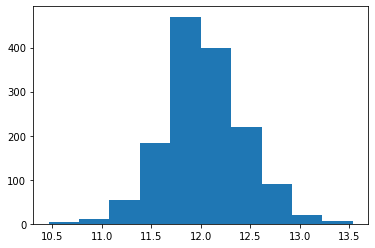

In [803]:
# Skewed but taking logs means that errors in preeicting expensive and cheap houses will have equal effect
plt.hist(np.log(train["SalePrice"]))

In [804]:
# Checking missing values
train.isnull().sum()
test.isnull().sum()

# Removing feautures with over 700 missing values in either test or train
def too_many_missing_values(data):
    data.drop(["Alley","PoolQC","Fence","MiscFeature","FireplaceQu"], axis = 1,inplace = True)
    return data

train = too_many_missing_values(train)
test = too_many_missing_values(test)

In [805]:
print(str(train.shape)+", "+str(test.shape))

(1460, 76), (1459, 75)


In [806]:
# Filling numeric missing values
cols = ["LotFrontage","GarageYrBlt","MasVnrArea","TotalBsmtSF","BsmtFinSF1","BsmtFinSF2","BsmtUnfSF","BsmtFullBath","BsmtHalfBath","GarageCars","GarageArea"]
def fill_na_numeric(data):
    for col in cols:
        if col == "MasVnrArea" or col == "TotalBsmtSF" or col == "BsmtFinSF1" or col == "BsmtFinSF2" or col == "BsmtUnfSF" or col == "BsmtFullBath" or col == "BsmtHalfBath" or col=="GarageCars" or col=="GarageArea":
            data[col] = data[col].fillna(0)
        else:
            data[col] = data[col].fillna(data[col].mean())
    return data

train = fill_na_numeric(train)
test = fill_na_numeric(test)

In [807]:
print(str(train.shape)+", "+str(test.shape))

(1460, 76), (1459, 75)


In [808]:
# Filling missing values for the categorical data
def fill_na_categorical(data):
    object_features = data.select_dtypes(include=['object']).copy()
    categorical_features = object_features.columns

    for feature in categorical_features:
        data[feature] = data[feature].fillna(data[feature].mode()[0])

    return data

train = fill_na_categorical(train)
test = fill_na_categorical(test)

In [809]:
# Removing labels from training dataset
# Forming train_X and train_y, test_X
train_y = np.log(train["SalePrice"])
train = train.drop("SalePrice",axis=1)

In [810]:
# Now need to encode these categorical features
def encode_categorical_non_ordinal(data):

    # Specifying the categorical features that have an order
    data["LotShape"].replace(["Reg", "IR1", "IR2", "IR3"], [0,1,2,3], inplace = True)
    data["LandContour"].replace(["Lvl", "Bnk", "HLS", "Low"], [0,1,2,3], inplace = True)
    data["LandSlope"].replace(["Gtl", "Mod", "Sev"], [0,1,2], inplace = True)
    data["ExterQual"].replace(["Ex", "Gd", "TA", "Fa", "Po"], [0,1,2,3,4], inplace = True)
    data["ExterCond"].replace(["Ex", "Gd", "TA", "Fa", "Po"], [0,1,2,3,4], inplace = True)
    data["BsmtQual"].replace(["Ex", "Gd", "TA", "Fa", "Po","NA"], [0,1,2,3,4,5], inplace = True)
    data["BsmtCond"].replace(["Ex", "Gd", "TA", "Fa", "Po","NA"], [0,1,2,3,4,5], inplace = True)
    data["BsmtExposure"].replace(["Gd", "Av", "Mn", "No","NA"], [0,1,2,3,4], inplace = True)
    data["BsmtFinType1"].replace(["GLQ", "ALQ", "BLQ", "Rec","LwQ", "Unf", "NA"], [0,1,2,3,4,5,6], inplace = True)
    data["BsmtFinType2"].replace(["GLQ", "ALQ", "BLQ", "Rec","LwQ", "Unf", "NA"], [0,1,2,3,4,5,6], inplace = True)
    data["HeatingQC"].replace(["Ex", "Gd", "TA", "Fa", "Po"], [0,1,2,3,4], inplace = True)
    data["KitchenQual"].replace(["Ex", "Gd", "TA", "Fa", "Po"], [0,1,2,3,4], inplace = True)
    data["Functional"].replace(["Typ","Min1", "Min2", "Mod", "Maj1", "Maj2", "Sev", "Sal"], [0,1,2,3,4,5,6,7], inplace = True)
    data["GarageFinish"].replace(["Fin","RFn","Unf","NA"], [0,1,2,3], inplace = True)
    data["GarageQual"].replace(["Ex", "Gd", "TA", "Fa", "Po","NA"], [0,1,2,3,4,5], inplace = True)
    data["GarageCond"].replace(["Ex", "Gd", "TA", "Fa", "Po","NA"], [0,1,2,3,4,5], inplace = True)

    return data

train = encode_categorical_non_ordinal(train)
test = encode_categorical_non_ordinal(test)

# Print shape before one hot encoding to ensure it is the same after
print(str(train.shape)+", "+str(test.shape))

(1460, 75), (1459, 75)


In [811]:
# One hot encoder performed on train+test set combined and then seperated after
combined_data = pd.concat([train,test],axis=0)

def one_hot_encoder(data):
    object_features = data.select_dtypes(include=['object']).copy()
    categorical_features = object_features.columns
    ordinal_categorical = ["LotShape","LandContour","LandSlope","ExterQual","ExterCond","BsmtQual","BsmtCond","BsmtExposure","BsmtFinType1","BsmtFinType2","HeatingQC","KitchenQual","Functional","GarageFinish","GarageQual","GarageCond"]

    # One hot encoding for the categorial features that have no order
    for feature in categorical_features:
        if feature not in ordinal_categorical:
            dummy = pd.get_dummies(data[feature],prefix=feature)
            data.drop([feature],axis=1,inplace=True)
            data = pd.concat([data,dummy],axis=1)

    return data

combined_data = one_hot_encoder(combined_data)

# Splitting back into training and test set
train = combined_data.iloc[:1460, :]
test = combined_data.iloc[1460:, :]

# Checking the train and test shape matched from above
print(str(train.shape)+", "+str(test.shape))

(1460, 214), (1459, 214)


In [812]:
#Saving ID's for training and test before standardization
train_id = train["Id"]
train = train.drop("Id",axis=1)
test_id = test["Id"]
test = test.drop("Id",axis=1)

In [813]:
# Forming train_X and test_X
train_X = train
test_X = test

# Scaling function
def scale_data(data):
    scaler = StandardScaler()
    scaler.fit(data)
    data = pd.DataFrame(scaler.transform(data),columns = data.columns)

    return data

#Scaling the data
train_X = scale_data(train_X)
test_X = scale_data(test_X)


In [814]:
# Lasso Model

# Defining and training
lasso_model = Lasso(alpha=0.006)
lasso_model.fit(train_X,train_y)

# Predicting
test_y = pd.DataFrame(lasso_model.predict(test_X))

# Creating submission file
submission_df = test_id
submission_df = pd.concat([test_id,np.exp(test_y)],axis=1)
submission_df.to_csv('lasso_submission.csv', index = False)

In [815]:
# XGBoost

# Defining and training
# xgb_model = xgb.XGBRegressor()
# xgb_model.fit(train_X,train_y)

# # Predicting
# test_y = pd.DataFrame(xgb_model.predict(test_X))

# # Creating submission file
# submission_df = test_id
# submission_df = pd.concat([test_id,np.exp(test_y)],axis=1)
# submission_df.to_csv('XGB_submission.csv', index = False)

/Users/olivergibbons/opt/anaconda3/envs/personal_env/lib/python3.10/site-packages/xgboost/data.py:250: FutureWarning: pandas.Int64Index is deprecated and will be removed from pandas in a future version. Use pandas.Index with the appropriate dtype instead.
  elif isinstance(data.columns, (pd.Int64Index, pd.RangeIndex)):
